In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

np.set_printoptions(suppress=True) #for printing 
import swifter


In [2]:
def get_weather_data(file_name) : 
    #Getting weather data -------------------------------------------------------------
    print('Reading weather ...')
    weather = pd.read_csv(file_name)
    print('File read.') 
    #Convert to datetime objs 
    weather['date'] = pd.to_datetime(weather['date'], format='%d-%b-%Y') 
    weather['YEAR'] = weather.swifter.apply(lambda x : x['date'].year, axis = 1)
    weather['MONTH'] = weather.swifter.apply(lambda x : x['date'].month, axis = 1)
    weather['DAY'] = weather.swifter.apply(lambda x : x['date'].day, axis = 1)
    #Drop irrelevant fields (soil/grass temp)
    weather = weather.drop(columns=['ind', 'ind.1', 'ind.2', 'gmin', 'soil', 'date', 'hm', 'ddhm', 'hg', 'cbl', 'g_rad', 'pe', 'evap',
                                    'smd_wd', 'smd_md', 'smd_pd', 'igmin', 'ind.3', 'ind.4', 'ind.5'])
    weather = weather.rename(columns={"date":"date", "rain":"RAIN", "maxtp":"MAX_TEMP", 
                                    "mintp":"MIN_TEMP", "wdsp":"MEAN WIND SPEED", "sun":"SUNSHINE", "dos": "SNOW LEVEL"})
    #Convert fields to floats 
    weather['RAIN'] =  weather.swifter.apply(lambda x : float(x['RAIN']), axis = 1)
    weather['MAX_TEMP'] =  weather.swifter.apply(lambda x : 0 if x['MAX_TEMP'] == ' ' else float(x['MAX_TEMP']), axis = 1)
    weather['MIN_TEMP'] =  weather.swifter.apply(lambda x : 0 if x['MIN_TEMP'] == ' ' else float(x['MIN_TEMP']), axis = 1)
    return weather 

def create_bike_data(file_name, weather_file, suppress_outliers=False, suppress=150) : 
    file = pd.read_csv(file_name)
    print("File ", file_name, " read.")
    #Drop irrelevant fields 
    data = file.drop(columns=['STATION ID', 'LAST UPDATED', 'NAME', 'STATUS', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'AVAILABLE BIKES'])
    #Convert time to datetime objects for comparison 
    data['TIME'] = pd.to_datetime(data['TIME'])
    # Sort by time 
    data = data.sort_values(by=['TIME'])

    # Bikes bought (i.e a bike used) at a time = Decrease in Available Bikes from previous time to now
    data['TOTAL AVAILABLE BIKES'] = data.groupby(['TIME'])['AVAILABLE BIKE STANDS'].transform('sum')
    data = data.drop_duplicates(subset=['TIME'])
    prev_row_availability = 0
    def calculateBikeUsage(x) : 
        nonlocal prev_row_availability
        availBikes = x['TOTAL AVAILABLE BIKES']
        inUse = 0
        if (availBikes >= prev_row_availability) : #If there is an increase in available bikes or doesnt change, ignore
            inUse = 0
        else : inUse = prev_row_availability - availBikes 
        prev_row_availability = availBikes 
        return inUse

    data['BIKES TAKEN'] = data.swifter.apply(lambda x : calculateBikeUsage(x), axis = 1)
    # Total bike stands
    bike_stands = data.groupby(['TIME'])['BIKE STANDS'].transform('sum')
    TOTAL_BIKE_STANDS = bike_stands.max()
    # Drop duplicates and drop now irrelevant field 
    data = data.drop_duplicates(subset=['TIME'])
    data = data.drop(columns=["AVAILABLE BIKE STANDS", 'BIKE STANDS', 'TOTAL AVAILABLE BIKES']) 
    data = data.reset_index(drop=True)
    #Split up time field 
    data['YEAR'] = data.swifter.apply(lambda x : x['TIME'].year, axis = 1)
    data['MONTH'] = data.swifter.apply(lambda x : x['TIME'].month, axis = 1)
    data['DAY'] = data.swifter.apply(lambda x : x['TIME'].day, axis = 1)
    data['HOUR'] = data.swifter.apply(lambda x : x['TIME'].hour, axis = 1)
    data['MINUTE'] = data.swifter.apply(lambda x : x['TIME'].minute, axis = 1)
    # Sin and cosine to represent cyclic data - i.e month, day, hour, minutes
    #Month 
    monthAngle = data['MONTH']*(2.*np.pi/30)
    data['MONTH_SIN'] = np.sin(monthAngle)
    data['MONTH_COS'] = np.cos(monthAngle)
    #Day 
    dayAngle = np.sin(data['DAY']*(2.*np.pi/30))
    data['DAY_SIN'] = np.sin(dayAngle)
    data['DAY_COS'] = np.cos(dayAngle)
    #Hour 
    hourAngle = data['HOUR']*(2.*np.pi/30)
    data['HOUR_SIN'] = np.sin(hourAngle)
    data['HOUR_COS'] = np.cos(hourAngle)
    #Minute 
    minuteAngle = data['MINUTE']*(2.*np.pi/30)
    data['MINUTE_SIN'] = np.sin(minuteAngle)
    data['MINUTE_COS'] = np.cos(minuteAngle)

    weather = get_weather_data(weather_file)
    
    dataset = data.merge(weather)

    if (suppress_outliers) : dataset = dataset.loc[dataset['BIKES TAKEN'] < suppress] 

    print(dataset.to_string(max_rows=20))
    return dataset

dataset = create_bike_data('data.csv', 'weather.csv', suppress_outliers=True)

File  data.csv  read.


Pandas Apply:   0%|          | 0/139483 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Reading weather ...
File read.


Pandas Apply:   0%|          | 0/1979 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1979 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1979 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1979 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1979 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1979 [00:00<?, ?it/s]

                      TIME  BIKES TAKEN  YEAR  MONTH  DAY  HOUR  MINUTE  MONTH_SIN  MONTH_COS   DAY_SIN   DAY_COS  HOUR_SIN  HOUR_COS    MINUTE_SIN  MINUTE_COS  MAX_TEMP  MIN_TEMP  RAIN  MEAN WIND SPEED  SUNSHINE  SNOW LEVEL
0      2018-08-01 12:30:02            0  2018      8    1    12      30   0.994522  -0.104528  0.206417  0.978464  0.587785 -0.809017 -2.449294e-16         1.0      18.5      11.9   5.8              8.2       0.8           0
1      2018-08-01 12:35:02            2  2018      8    1    12      35   0.994522  -0.104528  0.206417  0.978464  0.587785 -0.809017  8.660254e-01         0.5      18.5      11.9   5.8              8.2       0.8           0
2      2018-08-01 12:40:02            0  2018      8    1    12      40   0.994522  -0.104528  0.206417  0.978464  0.587785 -0.809017  8.660254e-01        -0.5      18.5      11.9   5.8              8.2       0.8           0
3      2018-08-01 12:45:02            0  2018      8    1    12      45   0.994522  -0.104528  0.206

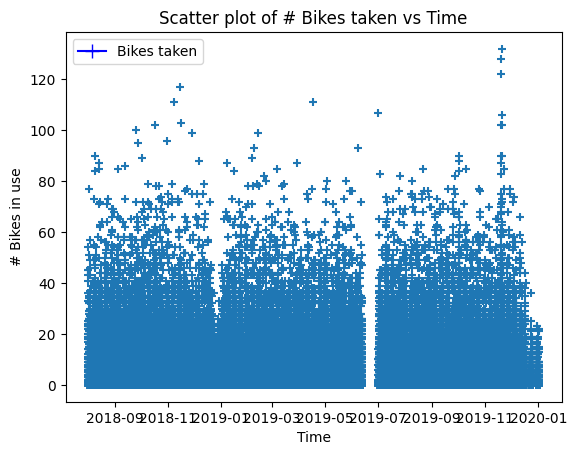

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
time = dataset['TIME']
bikesInUse = dataset['BIKES TAKEN'] #Get rid of extreme outliers (just for displaying)
#Display data of IN USE vs Time 
plt.scatter(time, bikesInUse, marker="+")
plt.xlabel("Time")
plt.ylabel("# Bikes in use")
plt.title("Scatter plot of # Bikes taken vs Time")
plt.savefig("graphs/scatter2019.png") 
legend = [mlines.Line2D([], [], color='blue', marker='+', markersize=10, label='Bikes taken')]
plt.legend(handles=legend)
plt.show()
plt.clf() 



In [ ]:
# Testing Polynomial Features ----------- DO NOT RUN -------------------------------------
mean_error=[]; std_error=[]
p_range = [1,2,3,4,5]
for p in p_range:
    #Feature engineering - polynomnial features for weather
    poly = PolynomialFeatures(p)

    #Standardising 
    weatherValues = np.column_stack((dataset['RAIN'], dataset['MAX_TEMP'], 
                                    dataset['MIN_TEMP'], dataset['MEAN WIND SPEED'],
                                    dataset['SUNSHINE'], dataset['SNOW LEVEL']))
    polyWeatherValues = poly.fit_transform(weatherValues)
    scaler = StandardScaler().fit(weatherValues)

    weatherScaled = StandardScaler().fit_transform(weatherValues)
    print("# of Poly degree :  ", p)
    X = np.column_stack((dataset['YEAR'], dataset['MONTH'], dataset['DAY'], 
                     dataset['HOUR'], dataset['MINUTE'], #These are kept just for the axis, deleted after split
                     weatherScaled,
                     dataset['MONTH_SIN'], dataset['MONTH_COS'],
                     dataset['DAY_SIN'], dataset['DAY_COS'],
                     dataset['HOUR_SIN'], dataset['HOUR_COS'],
                     dataset['MINUTE_SIN'], dataset['MINUTE_COS']))
    #X = np.column_stack((dataset['YEAR'], dataset['MONTH'], dataset['DAY'], dataset['HOUR'], dataset['MINUTE'], dataset['MONTH'] ** 2, dataset['HOUR'] ** 2, dataset['HOUR'] ** 3, dataset['MINUTE'] ** 2, dataset['RAIN'] ** 2, dataset['RAIN'], dataset['MAX_TEMP'], dataset['MIN_TEMP']))

    y = dataset['BIKES TAKEN']

    # 80% training - 20% test split 
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
    XTestDates = Xtest[:, [0,1,2,3,4]]
    Xtrain = np.delete(Xtrain, [0, 1,2,3,4], axis=1) # Delete Month, Day, Hour, Minute as they are now representated as cosine/sin
    Xtest = np.delete(Xtest, [0, 1,2,3,4], axis=1)
    model = MLPRegressor(hidden_layer_sizes=(20), max_iter=1000)
    scores = cross_val_score(model, Xtrain, ytrain)
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())

plt.errorbar(p_range,mean_error,yerr=std_error,linewidth=3)
plt.xlabel("Degree of Polynomial Features")
plt.ylabel("R^2")
plt.show()
plt.clf()

In [66]:
#Feature engineering - polynomnial features for weather
poly = PolynomialFeatures(3)

def create_training_sets(dataset) : 

    # date_strings = YEAR-MONTH-DAY HOUR 
    def toDateTime(set) : 
        return np.array(list(map(lambda x : str(int(x[0])) + "-" + str(int(x[1])).zfill(2) + "-" + str(int(x[2])).zfill(2) + " " + str(int(x[3])).zfill(2) + ":" + str(int(x[4])).zfill(2)
                                    , set))) 

    poly = PolynomialFeatures(3)

    #Standardising 
    weatherValues = np.column_stack((dataset['RAIN'], dataset['MAX_TEMP'], 
                                    dataset['MIN_TEMP'], dataset['MEAN WIND SPEED'],
                                    dataset['SUNSHINE'], dataset['SNOW LEVEL']))
    polyWeatherValues = poly.fit_transform(weatherValues)
    scaler = StandardScaler().fit(weatherValues)

    weatherScaled = StandardScaler().fit_transform(weatherValues)

    X = np.column_stack((dataset['YEAR'], dataset['MONTH'], dataset['DAY'], 
                     dataset['HOUR'], dataset['MINUTE'], #These are kept just for the axis, deleted after split
                     weatherScaled,
                     dataset['MONTH_SIN'], dataset['MONTH_COS'],
                     dataset['DAY_SIN'], dataset['DAY_COS'],
                     dataset['HOUR_SIN'], dataset['HOUR_COS'],
                     dataset['MINUTE_SIN'], dataset['MINUTE_COS']))
    y = dataset['BIKES TAKEN']

    # 80% training - 20% test split 
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
    tempDates = Xtest[:, [0,1,2,3,4]]
    date_strings = toDateTime(tempDates)
    Xtest_dates = pd.to_datetime(date_strings, format="%Y-%m-%d %H:%M")
    Xtrain = np.delete(Xtrain, [0, 1,2,3,4], axis=1) # Delete Month, Day, Hour, Minute as they are now representated as cosine/sin
    Xtest = np.delete(Xtest, [0, 1,2,3,4], axis=1)
    return [Xtrain, Xtest, ytrain, ytest, Xtest_dates]

Xtrain, Xtest, ytrain, ytest, Xtest_dates = create_training_sets(dataset)

-------------  DO NOT RUN THE NEXT 3 CELLS (TAKES SOME TIME) ----------------------

In [ ]:
#Neural network setup - Finding best hidden layer size, regularisation and iterations 
#Hidden layer 
mean_error=[]; std_error=[]
hidden_layer_range = [8, 16, 24, 30]
for n in hidden_layer_range:
    print("hidden layer size ", n)
    model = MLPRegressor(hidden_layer_sizes=(n), max_iter=500)
    scores = cross_val_score(model, Xtrain, ytrain)
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())
plt.errorbar(hidden_layer_range,mean_error,yerr=std_error,linewidth=3)
plt.xlabel("# hidden layer nodes")
plt.ylabel("R^2")
plt.show()
plt.clf()


In [ ]:
#Regularisation
mean_error=[]; std_error=[]
C_range = [1,5,10,100,1000]
for Ci in C_range:
    print("C : ", Ci)
    model = MLPRegressor(hidden_layer_sizes=(23), alpha = 1.0/Ci, max_iter=500)
    scores = cross_val_score(model, Xtrain, ytrain)
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())

plt.errorbar(C_range,mean_error,yerr=std_error,linewidth=3)
plt.xlabel("C") 
plt.ylabel("R^2")
plt.show()
plt.clf()

In [ ]:
#Iterations
mean_error=[]; std_error=[]
iter_range = [200,500,700,1000]
for iterations in iter_range:
    print("Iterations : ", iterations)
    model = MLPRegressor(hidden_layer_sizes=(23), alpha = 1.0/10, max_iter=iterations)
    scores = cross_val_score(model, Xtrain, ytrain)
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())

plt.errorbar(iter_range,mean_error,yerr=std_error,linewidth=3)
plt.xlabel("Iterations") 
plt.ylabel("R^2")
plt.show()
plt.clf()

In [55]:
HIDDEN_SIZE = 20 # Selected from analysing the f1 score 
C = 10
ITERATIONS = 1000


In [7]:
model = MLPRegressor(hidden_layer_sizes=(HIDDEN_SIZE), alpha=1.0/C, verbose=True, max_iter=ITERATIONS).fit(Xtrain, ytrain)
print("Model trained.")
print("Model # features : ", model.n_features_in_)



Iteration 1, loss = 34.58868795
Iteration 2, loss = 32.52148215
Iteration 3, loss = 32.35043722
Iteration 4, loss = 32.22523543
Iteration 5, loss = 32.11911355
Iteration 6, loss = 32.03178561
Iteration 7, loss = 31.93831532
Iteration 8, loss = 31.85114858
Iteration 9, loss = 31.77939317
Iteration 10, loss = 31.71182152
Iteration 11, loss = 31.65294817
Iteration 12, loss = 31.58749996
Iteration 13, loss = 31.52969168
Iteration 14, loss = 31.47661194
Iteration 15, loss = 31.41623960
Iteration 16, loss = 31.36065339
Iteration 17, loss = 31.30220973
Iteration 18, loss = 31.24838678
Iteration 19, loss = 31.18891105
Iteration 20, loss = 31.13892834
Iteration 21, loss = 31.08971861
Iteration 22, loss = 31.04338809
Iteration 23, loss = 31.00178764
Iteration 24, loss = 30.95870283
Iteration 25, loss = 30.92498855
Iteration 26, loss = 30.88698285
Iteration 27, loss = 30.85010261
Iteration 28, loss = 30.81809504
Iteration 29, loss = 30.78778598
Iteration 30, loss = 30.75694395
Iteration 31, loss 

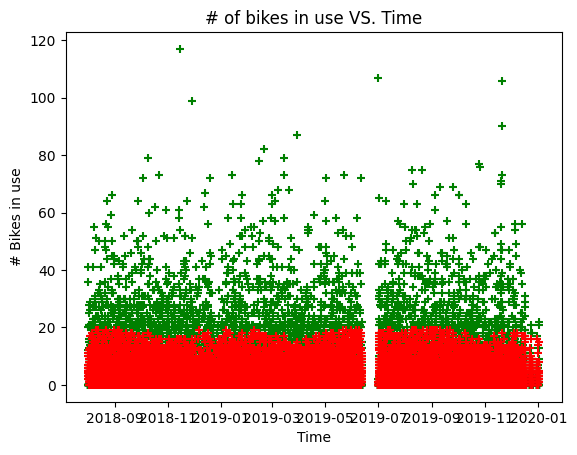

<Figure size 640x480 with 0 Axes>

In [8]:
#Graphs and Metrics of trained neural network 
preds = model.predict(Xtest)
#Round predictions to whole numbers - 0 if negative 
def integerise(num) : 
    if num > 0 : return round(num)
    else : return 0

preds = np.array(list(map(integerise, preds)))

#Graph predictions vs actual for test set 
plt.scatter(Xtest_dates, ytest, c='g', marker="+")
plt.scatter(Xtest_dates, preds, c='r', marker="+")

plt.xlabel("Time")
plt.ylabel("# Bikes in use")
plt.title("# of bikes in use VS. Time")
plt.savefig("graphs/neural2019TestScatter.png")
plt.show() 
plt.clf() 


In [9]:
#Metrics 
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
print("Mean absolute error : " + str(mean_absolute_error(ytest, preds)))
print("Explained variance score : " + str(explained_variance_score(ytest, preds)))
print("R2 Score : " + str(r2_score(ytest, preds)))


Mean absolute error : 4.6707177170717715
Explained variance score : 0.17910140565713029
R2 Score : 0.17907004617099642


In [10]:
# Compare to dummy classifier 
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy='median')
dummy.fit(Xtrain, ytrain)
dummyPreds = dummy.predict(Xtest)
print("Mean Strategy Dummy Scores -----------------------------------------------")
print("Mean absolute error : " + str(mean_absolute_error(ytest, dummyPreds)))
print("Explained variance score : " + str(explained_variance_score(ytest, dummyPreds)))
print("R2 Score : " + str(r2_score(ytest, dummyPreds)))

Mean Strategy Dummy Scores -----------------------------------------------
Mean absolute error : 4.1398867139886715
Explained variance score : 0.0
R2 Score : -0.247827298411194


In [11]:
# Pandemic period 
pandemic_2020_data = create_bike_data("pandemic_2020.csv", "pandemic_weather.csv", suppress_outliers=True)
pandemic_2021_data = create_bike_data("pandemic_2021.csv", "pandemic_weather.csv", suppress_outliers=True)

File  pandemic_2020.csv  read.


Pandas Apply:   0%|          | 0/82876 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/82876 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/82876 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/82876 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/82876 [00:00<?, ?it/s]

Reading weather ...
File read.


Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

                     TIME  BIKES TAKEN  YEAR  MONTH  DAY  HOUR  MINUTE  MONTH_SIN  MONTH_COS   DAY_SIN   DAY_COS  HOUR_SIN  HOUR_COS    MINUTE_SIN  MINUTE_COS  MAX_TEMP  MIN_TEMP  RAIN  MEAN WIND SPEED  SUNSHINE  SNOW LEVEL
0     2020-03-20 00:00:02            0  2020      3   20     0       0   0.587785   0.809017 -0.761760  0.647859  0.000000  1.000000  0.000000e+00         1.0       8.7      -2.7   0.0             12.4       7.7           0
1     2020-03-20 00:05:03            0  2020      3   20     0       5   0.587785   0.809017 -0.761760  0.647859  0.000000  1.000000  8.660254e-01         0.5       8.7      -2.7   0.0             12.4       7.7           0
2     2020-03-20 00:10:02            0  2020      3   20     0      10   0.587785   0.809017 -0.761760  0.647859  0.000000  1.000000  8.660254e-01        -0.5       8.7      -2.7   0.0             12.4       7.7           0
3     2020-03-20 00:15:02            1  2020      3   20     0      15   0.587785   0.809017 -0.761760  

Pandas Apply:   0%|          | 0/103038 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103038 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103038 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/103038 [00:00<?, ?it/s]

Reading weather ...
File read.


Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/674 [00:00<?, ?it/s]

                      TIME  BIKES TAKEN  YEAR  MONTH  DAY  HOUR  MINUTE  MONTH_SIN  MONTH_COS   DAY_SIN   DAY_COS  HOUR_SIN  HOUR_COS    MINUTE_SIN  MINUTE_COS  MAX_TEMP  MIN_TEMP  RAIN  MEAN WIND SPEED  SUNSHINE  SNOW LEVEL
0      2021-01-01 00:00:03            0  2021      1    1     0       0   0.207912   0.978148  0.206417  0.978464  0.000000  1.000000  0.000000e+00         1.0       5.0      -1.9   0.0              8.8       6.6           0
1      2021-01-01 00:05:03            0  2021      1    1     0       5   0.207912   0.978148  0.206417  0.978464  0.000000  1.000000  8.660254e-01         0.5       5.0      -1.9   0.0              8.8       6.6           0
2      2021-01-01 00:10:03            0  2021      1    1     0      10   0.207912   0.978148  0.206417  0.978464  0.000000  1.000000  8.660254e-01        -0.5       5.0      -1.9   0.0              8.8       6.6           0
3      2021-01-01 00:15:03            0  2021      1    1     0      15   0.207912   0.978148  0.206

In [12]:
# Predicting pandemic period 
def createFeatures(dataset) : 
    poly = PolynomialFeatures(3)

    #Standardising 
    weatherValues = np.column_stack((dataset['RAIN'], dataset['MAX_TEMP'], 
                                    dataset['MIN_TEMP'], dataset['MEAN WIND SPEED'],
                                    dataset['SUNSHINE'], dataset['SNOW LEVEL']))
    polyWeatherValues = poly.fit_transform(weatherValues)
    scaler = StandardScaler().fit(weatherValues)

    weatherScaled = StandardScaler().fit_transform(weatherValues)

    X = np.column_stack((weatherScaled,
                        dataset['MONTH_SIN'], dataset['MONTH_COS'],
                        dataset['DAY_SIN'], dataset['DAY_COS'],
                        dataset['HOUR_SIN'], dataset['HOUR_COS'],
                        dataset['MINUTE_SIN'], dataset['MINUTE_COS']))
    return X

#Predict Pandemic period using trained model 
#Features
pd_feats_2020 = createFeatures(pandemic_2020_data)
pd_feats_2021 = createFeatures(pandemic_2021_data)
#Predictions 
pd_preds_2020 = model.predict(pd_feats_2020)
pd_preds_2020 = np.array(list(map(integerise, pd_preds_2020)))
pd_preds_2021 = model.predict(pd_feats_2021)
pd_preds_2021 = np.array(list(map(integerise, pd_preds_2021)))


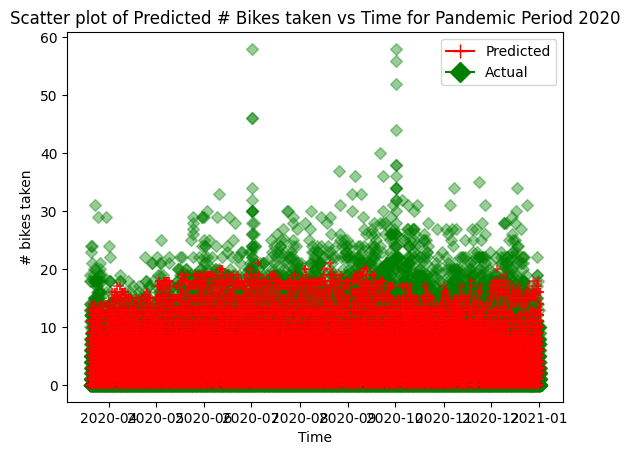

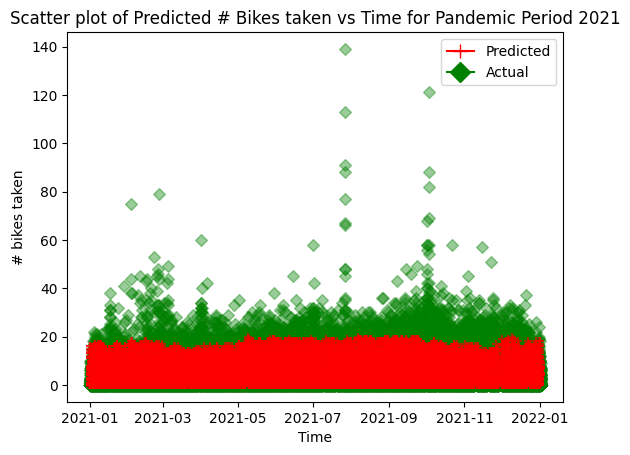

---------------------------2020---------------------------
Mean values
Pandemic :  2.099344780567857 
Predicted 2020 :  4.2506123828026015 

Standard Deviation values
Pandemic :  3.925851715306891 
Predicted 2020 :  3.4414836308175785 

Total Usage
Pandemic :  173979 
Predicted 2020 :  352261 
Percentage change of usage of Pandemic vs Predicted :  -50.61 %

Daily Usage Means
Pandemic :  604 
Predicted 2020 :  1223

---------------------------2021---------------------------
Mean values
Pandemic :  2.43784545145466 
Predicted 2021 :  4.06254796250425 

Standard Deviation values
Pandemic :  4.7335790080830815 
Predicted 2021 :  3.4279186956229575 

Total Usage
Pandemic :  250964 
Predicted 2021 :  418219 
Percentage change of usage of Pandemic vs Predicted :  -39.99 %

Daily Usage Means
Pandemic :  700 
Predicted 2021 :  1171


<Figure size 640x480 with 0 Axes>

In [13]:
# Comparison of Pandemic bikes usage vs Model Predicts 
#Display ---------------------------------------------------------------------------------
plt.scatter(pandemic_2020_data['TIME'], pandemic_2020_data['BIKES TAKEN'], marker="D", c='g', alpha=0.4)
plt.scatter(pandemic_2020_data['TIME'], pd_preds_2020,  marker="+", c='r', alpha=0.4)
plt.xlabel("Time")
plt.ylabel("# bikes taken")
plt.title("Scatter plot of Predicted # Bikes taken vs Time for Pandemic Period 2020")
legend = [mlines.Line2D([], [], color='red', marker='+', markersize=10, label='Predicted'),
          mlines.Line2D([], [], color='green', marker='D', markersize=10, label='Actual')]
plt.legend(handles=legend)
plt.show()
plt.clf() 

plt.scatter(pandemic_2021_data['TIME'], pandemic_2021_data['BIKES TAKEN'], marker="D", c='g', alpha=0.4)
plt.scatter(pandemic_2021_data['TIME'], pd_preds_2021,  marker="+", c='r', alpha=0.4)
plt.xlabel("Time")
plt.ylabel("# bikes taken")
plt.title("Scatter plot of Predicted # Bikes taken vs Time for Pandemic Period 2021")
legend = [mlines.Line2D([], [], color='red', marker='+', markersize=10, label='Predicted'),
          mlines.Line2D([], [], color='green', marker='D', markersize=10, label='Actual')]
plt.legend(handles=legend)
plt.show()
plt.clf() 

#Descriptive statistics 
print("---------------------------2020---------------------------")
print("Mean values")
print("Pandemic : ", pandemic_2020_data['BIKES TAKEN'].mean(), "\nPredicted 2020 : ", pd_preds_2020.mean(), "\n")
print("Standard Deviation values")
print("Pandemic : ", pandemic_2020_data['BIKES TAKEN'].std(), "\nPredicted 2020 : ", pd_preds_2020.std(), "\n")
predicted_total_usage_2020 = pd_preds_2020.sum()
pandemic_total_usage_2020 = pandemic_2020_data['BIKES TAKEN'].sum()
pandemic_total_usage_perc_2020 = round(((pandemic_total_usage_2020 - predicted_total_usage_2020) / predicted_total_usage_2020)*100, 2)
print("Total Usage")
print("Pandemic : ", pandemic_total_usage_2020, "\nPredicted 2020 : ", predicted_total_usage_2020, 
      "\nPercentage change of usage of Pandemic vs Predicted : ", pandemic_total_usage_perc_2020, "%")

daily_use_pandemic = pandemic_2020_data.groupby(by=["MONTH", "DAY"])["BIKES TAKEN"].transform('sum')
preds_with_days = pandemic_2020_data.copy(deep=True)
preds_with_days['BIKES TAKEN'] = pd_preds_2020
daily_use_predict = preds_with_days.groupby(by=["MONTH", "DAY"])["BIKES TAKEN"].transform('sum')

print("\nDaily Usage Means")
print("Pandemic : ", round(daily_use_pandemic.mean()), "\nPredicted 2020 : ", round(daily_use_predict.mean()))

print("\n---------------------------2021---------------------------")
print("Mean values")
print("Pandemic : ", pandemic_2021_data['BIKES TAKEN'].mean(), "\nPredicted 2021 : ", pd_preds_2021.mean(), "\n")
print("Standard Deviation values")
print("Pandemic : ", pandemic_2021_data['BIKES TAKEN'].std(), "\nPredicted 2021 : ", pd_preds_2021.std(), "\n")
predicted_total_usage_2021 = pd_preds_2021.sum()
pandemic_total_usage_2021 = pandemic_2021_data['BIKES TAKEN'].sum()
pandemic_total_usage_perc_2021 = round(((pandemic_total_usage_2021 - predicted_total_usage_2021) / predicted_total_usage_2021)*100, 2)
print("Total Usage")
print("Pandemic : ", pandemic_total_usage_2021, "\nPredicted 2021 : ", predicted_total_usage_2021, 
      "\nPercentage change of usage of Pandemic vs Predicted : ", pandemic_total_usage_perc_2021, "%")

daily_use_pandemic = pandemic_2021_data.groupby(by=["MONTH", "DAY"])["BIKES TAKEN"].transform('sum')
preds_with_days = pandemic_2021_data.copy(deep=True)
preds_with_days['BIKES TAKEN'] = pd_preds_2021
daily_use_predict = preds_with_days.groupby(by=["MONTH", "DAY"])["BIKES TAKEN"].transform('sum')

print("\nDaily Usage Means")
print("Pandemic : ", round(daily_use_pandemic.mean()), "\nPredicted 2021 : ", round(daily_use_predict.mean()))

In [78]:
#Training model to analyse post-pandemic period 23-01-2022 -> 20-11-2023
#Creating post pandemic data 
#Copy data to manipulate 
post_pandemic = create_bike_data(file_name="post_pandemic_data.csv", weather_file="post_pandemic_weather.csv", suppress_outliers=True)
#Feature creation
post_pandemic_features = createFeatures(post_pandemic)



File  post_pandemic_data.csv  read.


Pandas Apply:   0%|          | 0/33454 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/33454 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/33454 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/33454 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/33454 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/33454 [00:00<?, ?it/s]

Reading weather ...
File read.


Pandas Apply:   0%|          | 0/677 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/677 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/677 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/677 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/677 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/677 [00:00<?, ?it/s]

                     TIME  BIKES TAKEN  YEAR  MONTH  DAY  HOUR  MINUTE  MONTH_SIN  MONTH_COS       DAY_SIN   DAY_COS  HOUR_SIN  HOUR_COS    MINUTE_SIN  MINUTE_COS  MAX_TEMP  MIN_TEMP  RAIN  MEAN WIND SPEED  SUNSHINE  SNOW LEVEL
1     2022-02-01 00:30:02            3  2022      2    1     0      30   0.406737   0.913545  2.064170e-01  0.978464  0.000000  1.000000 -2.449294e-16         1.0      10.8       8.5   0.3             18.5       0.1           0
2     2022-02-01 01:00:03            0  2022      2    1     1       0   0.406737   0.913545  2.064170e-01  0.978464  0.207912  0.978148  0.000000e+00         1.0      10.8       8.5   0.3             18.5       0.1           0
3     2022-02-01 01:30:02            5  2022      2    1     1      30   0.406737   0.913545  2.064170e-01  0.978464  0.207912  0.978148 -2.449294e-16         1.0      10.8       8.5   0.3             18.5       0.1           0
4     2022-02-01 02:00:03            0  2022      2    1     2       0   0.406737   0.91

In [79]:
extended_dataset = pd.concat([dataset, pandemic_2020_data, pandemic_2021_data])
Xtrain, Xtest, ytrain, ytest, Xtest_dates = create_training_sets(extended_dataset)
print(Xtest_dates)

DatetimeIndex(['2019-09-28 01:10:00', '2021-01-01 09:45:00',
               '2021-10-07 17:00:00', '2019-02-05 02:35:00',
               '2021-06-29 04:45:00', '2019-04-16 19:50:00',
               '2021-09-05 02:00:00', '2020-08-14 15:55:00',
               '2020-07-28 17:25:00', '2018-08-02 16:40:00',
               ...
               '2019-09-30 08:20:00', '2021-01-02 03:25:00',
               '2021-03-18 20:20:00', '2018-12-12 11:40:00',
               '2019-11-20 01:15:00', '2020-04-14 19:35:00',
               '2021-07-25 07:00:00', '2021-02-23 16:20:00',
               '2021-06-27 19:30:00', '2018-11-30 18:40:00'],
              dtype='datetime64[ns]', length=65057, freq=None)


In [74]:
#Retraining model with pandemic data included 
extended_model = MLPRegressor(hidden_layer_sizes=(HIDDEN_SIZE), alpha=1.0/C, verbose=True, max_iter=ITERATIONS).fit(Xtrain, ytrain)

Iteration 1, loss = 20.07740994
Iteration 2, loss = 19.39144235
Iteration 3, loss = 19.30241840
Iteration 4, loss = 19.23289883
Iteration 5, loss = 19.16938746
Iteration 6, loss = 19.11542031
Iteration 7, loss = 19.07626131
Iteration 8, loss = 19.04332343
Iteration 9, loss = 19.01887532
Iteration 10, loss = 18.99219551
Iteration 11, loss = 18.96810786
Iteration 12, loss = 18.95130813
Iteration 13, loss = 18.93268853
Iteration 14, loss = 18.91845496
Iteration 15, loss = 18.90191855
Iteration 16, loss = 18.88778600
Iteration 17, loss = 18.87451997
Iteration 18, loss = 18.86265079
Iteration 19, loss = 18.85014499
Iteration 20, loss = 18.84123730
Iteration 21, loss = 18.82872451
Iteration 22, loss = 18.81880225
Iteration 23, loss = 18.80600728
Iteration 24, loss = 18.79857614
Iteration 25, loss = 18.78943075
Iteration 26, loss = 18.77730592
Iteration 27, loss = 18.76836161
Iteration 28, loss = 18.75859647
Iteration 29, loss = 18.74965573
Iteration 30, loss = 18.73947853
Iteration 31, loss 

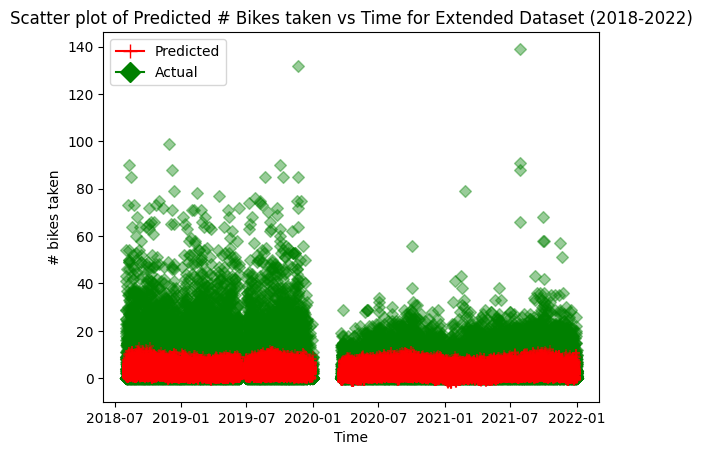

<Figure size 640x480 with 0 Axes>

In [75]:
testPreds = extended_model.predict(Xtest)

# Comparison of Bikes usage vs Model Predicts 
#Display ---------------------------------------------------------------------------------
plt.scatter(Xtest_dates, ytest, marker="D", c='g', alpha=0.4)
plt.scatter(Xtest_dates, testPreds,  marker="+", c='r', alpha=0.4)
plt.xlabel("Time")
plt.ylabel("# bikes taken")
plt.title("Scatter plot of Predicted # Bikes taken vs Time for Extended Dataset (2018-2022)")
legend = [mlines.Line2D([], [], color='red', marker='+', markersize=10, label='Predicted'),
          mlines.Line2D([], [], color='green', marker='D', markersize=10, label='Actual')]
plt.legend(handles=legend)
plt.show()
plt.clf() 

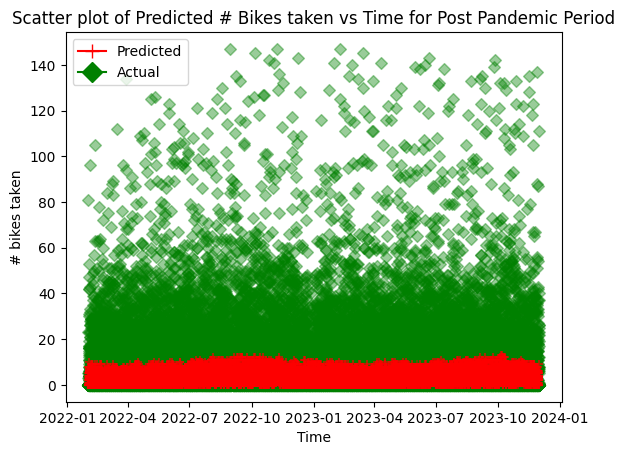

---------------------------Post Pandemic - Extended Model ---------------------------
Mean values
True :  7.677781952533032 
Predicted :  3.5467781326319745 

Standard Deviation values
True :  15.290342245731239 
Predicted :  2.4149287650476334 

Total Usage
True :  245213 
True :  113277 
Percentage change of usage of Post-Pandemic vs Predicted :  116.47 %

Daily Usage Means
True :  700 
Predicted :  326


<Figure size 640x480 with 0 Axes>

In [84]:
# Create predictions for post-pandemic period using extended-model and original model 
extended_pd_post_pandemic = extended_model.predict(post_pandemic_features)
extended_pd_post_pandemic = np.array(list(map(integerise, extended_pd_post_pandemic)))

original_pd_post_pandemic = model.predict(post_pandemic_features)
original_pd_post_pandemic = np.array(list(map(integerise, original_pd_post_pandemic)))

# Comparison of Pandemic bikes usage vs Model Predicts 
#Display ---------------------------------------------------------------------------------
plt.scatter(post_pandemic['TIME'], post_pandemic['BIKES TAKEN'], marker="D", c='g', alpha=0.4)
plt.scatter(post_pandemic['TIME'], extended_pd_post_pandemic,  marker="+", c='r', alpha=0.4)
plt.xlabel("Time")
plt.ylabel("# bikes taken")
plt.title("Scatter plot of Extended Model predictions of # bikes taken vs Time for Post Pandemic Period")
legend = [mlines.Line2D([], [], color='red', marker='+', markersize=10, label='Predicted'),
          mlines.Line2D([], [], color='green', marker='D', markersize=10, label='Actual')]
plt.legend(handles=legend)
plt.show()
plt.clf() 

#Descriptive statistics 
print("---------------------------Post Pandemic - Extended Model ---------------------------")
print("Mean values")
print("True : ", post_pandemic['BIKES TAKEN'].mean(), "\nPredicted : ", extended_pd_post_pandemic.mean(), "\n")
print("Standard Deviation values")
print("True : ", post_pandemic['BIKES TAKEN'].std(), "\nPredicted : ", extended_pd_post_pandemic.std(), "\n")
predicted_total_usage = extended_pd_post_pandemic.sum()
total_usage = post_pandemic['BIKES TAKEN'].sum()
total_usage_perc = round(((total_usage - predicted_total_usage) / predicted_total_usage)*100, 2)
print("Total Usage")
print("True : ", total_usage, "\nTrue : ", predicted_total_usage, 
      "\nPercentage change of usage of Post-Pandemic vs Predicted : ", total_usage_perc, "%")

daily_use = post_pandemic.groupby(by=["MONTH", "DAY"])["BIKES TAKEN"].transform('sum')
preds_with_days = post_pandemic.copy(deep=True)
preds_with_days['BIKES TAKEN'] = extended_pd_post_pandemic
daily_use_predict = preds_with_days.groupby(by=["MONTH", "DAY"])["BIKES TAKEN"].transform('sum')

print("\nDaily Usage Means")
print("True : ", round(daily_use_pandemic.mean()), "\nPredicted : ", round(daily_use_predict.mean()))


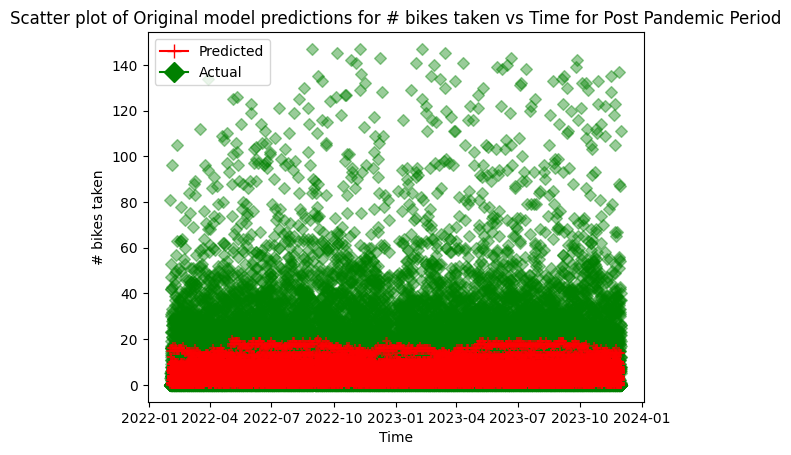

---------------------------Post Pandemic - Original Model ---------------------------
Mean values
True :  7.677781952533032 
Predicted :  5.2079028116976644 

Standard Deviation values
True :  15.290342245731239 
Predicted :  3.8557638431347043 

Total Usage
True :  245213 
Predicted :  166330 
Percentage change of usage of Post-Pandemic vs Predicted :  47.43 %

Daily Usage Means
True :  700 
Predicted :  478


<Figure size 640x480 with 0 Axes>

In [87]:
#Display ---------------------------------------------------------------------------------
plt.scatter(post_pandemic['TIME'], post_pandemic['BIKES TAKEN'], marker="D", c='g', alpha=0.4)
plt.scatter(post_pandemic['TIME'], original_pd_post_pandemic,  marker="+", c='r', alpha=0.4)
plt.xlabel("Time")
plt.ylabel("# bikes taken")
plt.title("Scatter plot of Original model predictions for # bikes taken vs Time for Post Pandemic Period")
legend = [mlines.Line2D([], [], color='red', marker='+', markersize=10, label='Predicted'),
          mlines.Line2D([], [], color='green', marker='D', markersize=10, label='Actual')]
plt.legend(handles=legend)
plt.show()
plt.clf() 

#Descriptive statistics 
print("---------------------------Post Pandemic - Original Model ---------------------------")
print("Mean values")
print("True : ", post_pandemic['BIKES TAKEN'].mean(), "\nPredicted : ", original_pd_post_pandemic.mean(), "\n")
print("Standard Deviation values")
print("True : ", post_pandemic['BIKES TAKEN'].std(), "\nPredicted : ", original_pd_post_pandemic.std(), "\n")
predicted_total_usage = original_pd_post_pandemic.sum()
total_usage = post_pandemic['BIKES TAKEN'].sum()
total_usage_perc = round(((total_usage - predicted_total_usage) / predicted_total_usage)*100, 2)
print("Total Usage")
print("True : ", total_usage, "\nPredicted : ", predicted_total_usage, 
      "\nPercentage change of usage of Post-Pandemic vs Predicted : ", total_usage_perc, "%")

daily_use = post_pandemic.groupby(by=["MONTH", "DAY"])["BIKES TAKEN"].transform('sum')
preds_with_days = post_pandemic.copy(deep=True)
preds_with_days['BIKES TAKEN'] = original_pd_post_pandemic
daily_use_predict = preds_with_days.groupby(by=["MONTH", "DAY"])["BIKES TAKEN"].transform('sum')

print("\nDaily Usage Means")
print("True : ", round(daily_use_pandemic.mean()), "\nPredicted : ", round(daily_use_predict.mean()))